In [1]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display

In [2]:
#parameters
L1= 4      #width
L2=4        #hight
k=1      #ثابت بولتزمن
steps=100   # Number of MC sweeps 
Temp =np.arange(0,7,0.01)  #Temperature range

#ثابت های تعامل اسپین
J1=1
J2=0.5
J3= 0.2

In [3]:
#functions
def initialstate(L1,L2):        #generating random spins for initial condition
    return np.random.choice([1, -1], size=(L1, L2))    

def calcMag(f):    #Calculate the magnetization
    return np.sum(f) / f.size   # to compensate for over-counting

def calcM_avg(z1,z2,z3,J1,J2,J3,T):    # Calculate average magnetization
    s_avg = relaxation(z1, z2, z3, J1, J2, J3, T)
    ss= (z1*J1 +z2*J2+z2*J3)* (s_avg) 
    return ss


def calcE(f,J1,J2,J3):      #Calculate Energy
    E = 0
    L1,L2 = f.shape
    for i in range(L1):
        for j in range(L2):
            E += -f[i, j] * dE(f,i,j,J1,J2,J3)
    return E/2   #to avoid double counting

def dE(f, i, j, J1, J2, J3):
    L1,L2 = f.shape
    ni = 0     #number of intractiojs
    # نزدیکترین همسایگی ها
    ni1 = J1* sum([f[(i - 1) % L1, j],f[(i + 1) % L1, j],f[i, (j - 1) % L2],f[i, (j + 1) % L2]])
    #همسایگی های دوم
    ni2 =J2* sum( [f[(i - 1) % L1, (j - 1) % L2],f[(i - 1) % L1, (j + 1) % L2],f[(i + 1) % L1, (j - 1) % L2],f[(i + 1) % L1, (j + 1) % L2]])
    #همسایگی های سوم
    ni3 = J3* sum([f[(i - 2) % L1, j],f[(i + 2) % L1, j],f[i, (j - 2) % L2],f[i, (j+ 2) % L2]])
    ni= ni1 +ni2 +ni3
    return ni
    
def relaxation(z1,z2,z3,J1,J2,J3,T, max=100, t=1e-6):      #Relaxation method to calculate average spin
    s_avg = 0.0
    for _ in range(max):
        if T > 0:
            s_avg_new = np.tanh((z1*J1*s_avg + z2*J2*s_avg + z3*J3*s_avg)/(k*T))
        else:
            s_avg_new = 1.0 if (z1*J1 + z2*J2 +z3*J3) > 0 else -1.0
        if abs(s_avg_new - s_avg) < t:
                return s_avg_new
        s_avg= s_avg_new
               
def MC (f,steps,T, J1, J2, J3):      #Perform Monte-Carlo sweeps
    L1, L2 = f.shape
    z1, z2, z3 = 4, 4, 4
    M_avg = calcM_avg(z1, z2, z3, J1, J2, J3, T)
    for _ in range(steps):
        i= np.random.randint(0, L1)
        j= np.random.randint(0, L2)
        E= dE(f, i, j, J1, J2, J3)
        E_now= -f[i,j]*(E+M_avg)     #spin=f[i,j]
        E_switch= f[i,j] *(E+M_avg) 
        delta_E=E_switch -E_now
        if T==0:
            if delta_E <= 0:  # If the change in energy is negative
                f[i, j] = -f[i, j]  # Accept move and flip spin
        elif np.random.rand()< np.exp(-delta_E /(k*T)):    # Accept with probability exp(-dU/kT)
            f[i, j] = -f[i, j]
    return f


def simulate_ising_model (L1,L2,steps,J1,J2,J3,Temp):
    mag=[]
    E_avg=[]
    for T in Temp:
        field = initialstate(L1, L2)
        final_field = field.copy()
        temp_mag = []
        temp_E = []
        for step in range(steps):
            final_field = MC(final_field,steps, T, J1, J2, J3)
            temp_mag.append(calcMag(final_field))
            temp_E.append(calcE(final_field, J1, J2, J3))
        avg_mag = np.mean(np.abs(temp_mag))
        mag.append(avg_mag)
        avg_E = np.mean(temp_E)
        E_avg.append(avg_E) 
    return  E_avg,mag

def simulating (L1,L2,steps,J1,J2,J3,Temp):
    magg=[]
    E_avgg=[]
    for T in Temp:
        field =  initialstate(L1, L2)
        final_field =field.copy()
        for step in range(steps):
            final_field =MC(final_field,steps, T, J1, J2, J3)
        avg_mag = calcMag(final_field)
        avg_E = calcE(final_field, J1, J2, J3)
        magg.append(np.abs(avg_mag))
        E_avgg.append(avg_E)
    return  E_avgg,magg


def plot_results(En_avg, mag,L1,L2,steps,Temp,J1,J2,J3):      #Plot the simulation results
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    
    axes[0].plot(Temp, En_avg, marker='.', color='IndianRed')
    axes[0].set_xlabel("Temperature (T)", fontsize=16)
    axes[0].set_ylabel("Energy", fontsize=16)
    axes[0].set_title("Average Energy vs Temperature", fontsize=18)
    
    axes[1].plot(Temp, mag, marker='.', color='RoyalBlue')
    axes[1].set_xlabel("Temperature (T)", fontsize=16)
    axes[1].set_ylabel("Magnetization", fontsize=16)
    axes[1].set_title("Magnetization vs Temperature", fontsize=18)

    
    plt.suptitle(f"Simulation of 2D Ising Model\n"
                 f"Lattice Dimension: {L1}x{L2}, Metropolis Step={steps}",
                 fontsize=20)
    plt.tight_layout()
    plt.show()

def plot_results__scatter(En_avg, mag,L1,L2,steps,Temp,J1,J2,J3):      #Plot the simulation results
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    
    axes[0].plot.scatter(Temp, En_avg, marker='.', color='IndianRed')
    axes[0].set_xlabel("Temperature (T)", fontsize=16)
    axes[0].set_ylabel("Energy", fontsize=16)
    axes[0].set_title("Average Energy vs Temperature", fontsize=18)
    
    axes[1].plot.scatter(Temp, mag, marker='.', color='RoyalBlue')
    axes[1].set_xlabel("Temperature (T)", fontsize=16)
    axes[1].set_ylabel("Magnetization", fontsize=16)
    axes[1].set_title("Magnetization vs Temperature", fontsize=18)

    
    plt.suptitle(f"Simulation of 2D Ising Model\n"
                 f"Lattice Dimension: {L1}x{L2}, Metropolis Step={steps}",
                 fontsize=20)
    plt.tight_layout()
    plt.show()

In [7]:
# Run the simulation and plot the results
#miangingiri ansambli
En_avg, mag = simulate_ising_model(L1,L2,steps,J1,J2,J3,Temp)
plot_results(En_avg, mag, L1,L2, steps,Temp,J1,J2,J3)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1312\891445572.py:59: RuntimeWarning: overflow encountered in exp
  elif np.random.rand()< np.exp(-delta_E /(k*T)):    # Accept with probability exp(-dU/kT)

KeyboardInterrupt



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10108\891445572.py:59: RuntimeWarning: overflow encountered in exp
  elif np.random.rand()< np.exp(-delta_E /(k*T)):    # Accept with probability exp(-dU/kT)


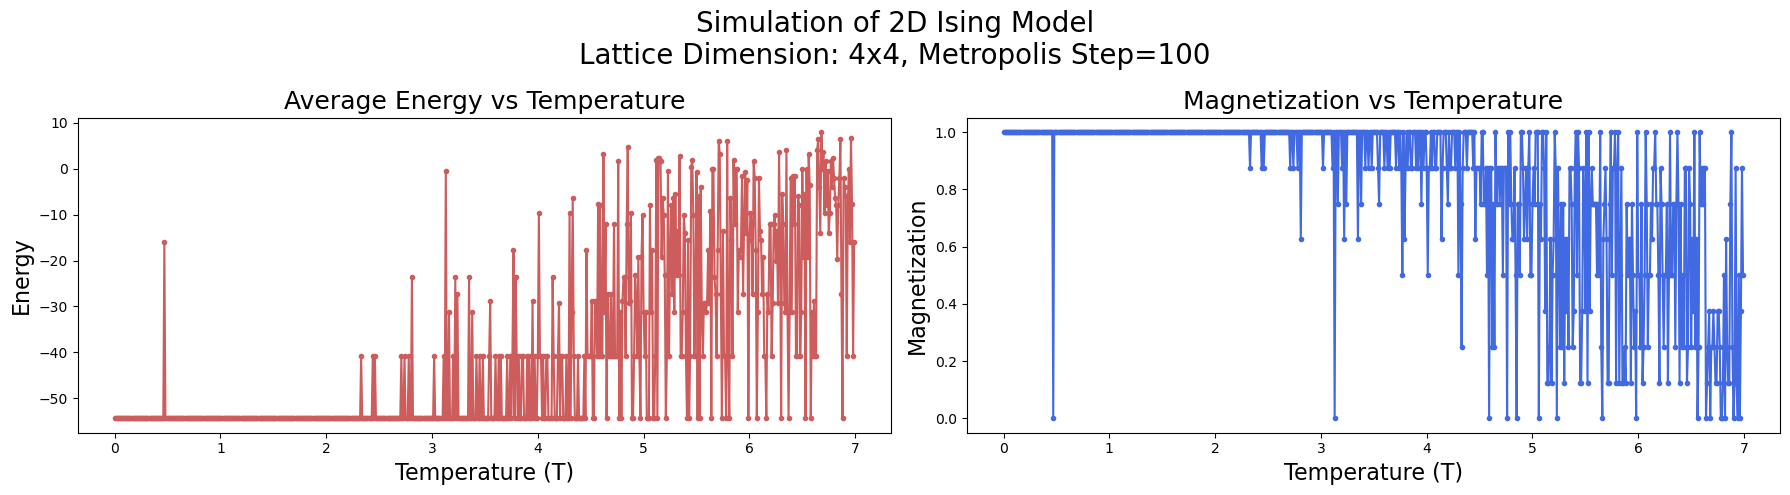

In [695]:
# Run the simulation and plot the results
#miangingiri zamani
En_avg, mag = simulating(L1,L2,steps,J1,J2,J3,Temp)
plot_results(En_avg, mag, L1,L2, steps,Temp,J1,J2,J3)

In [656]:
def display_spin_field_with_legend(field, new_size=(300, 300)):
    normalized_field = (field + 1) * 0.5 * 255 # Normalize to range 0-255
    img = Image.fromarray(np.uint8(normalized_field)).convert("L")
    img_resized = img.resize(new_size, Image.Resampling.LANCZOS)
    # Add legend
    legend_img = Image.new("RGB", (new_size[0], new_size[1] + 50), "white")
    legend_img.paste(img_resized, (0, 0))
    draw = ImageDraw.Draw(legend_img)
    draw.text((10, new_size[1] + 10), "Black: -1, White: +1", fill="black") 
    return legend_img

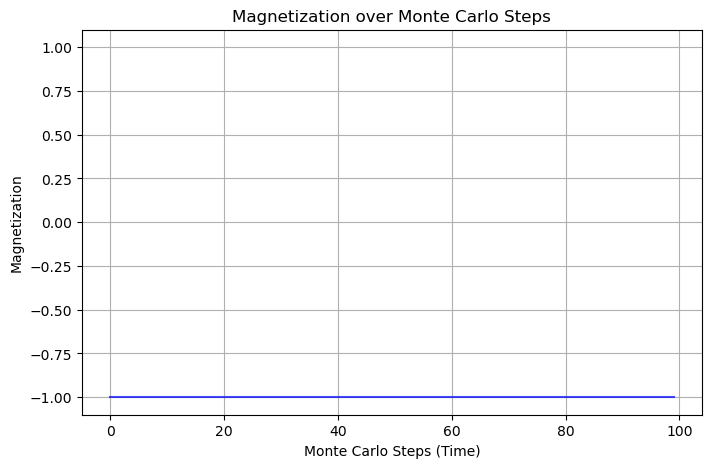

Initial Spin Configuration Image (Black = -1, White = +1):


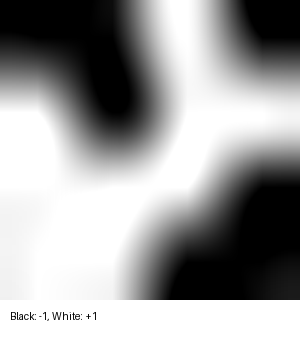

Final Spin Configuration Image (Black = -1, White = +1):


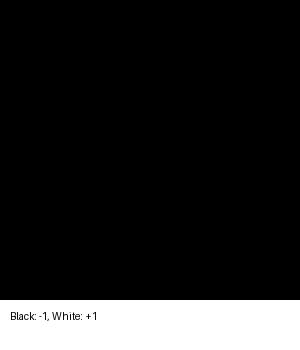

In [671]:
###### Run the Simulation ######
field = initialstate(L1, L2)
final_field = field.copy()
magnetizations = []
for step in range(steps):
    final_field = MC(final_field,steps, T, J1, J2, J3)
    magnetizations.append(calcMag(final_field))

# Plot Magnetization over time
plt.figure(figsize=(8, 5))
plt.plot(range(steps), magnetizations, color='blue', alpha=0.7)
plt.title("Magnetization over Monte Carlo Steps")
plt.xlabel("Monte Carlo Steps (Time)")
plt.ylabel("Magnetization")
plt.grid(True)
plt.ylim(-1.1, 1.1)
plt.show()

# Display initial and final spin configurations
initial_spin_image = display_spin_field_with_legend(field)
final_spin_image = display_spin_field_with_legend(final_field)
print("Initial Spin Configuration Image (Black = -1, White = +1):")
display(initial_spin_image)
print("Final Spin Configuration Image (Black = -1, White = +1):")
display(final_spin_image)

In [673]:
## change these parameters for a smaller (faster) simulation 
nt      = 88         #  number of temperature points
L1       = 8       #  size of the lattice, N x N
L2=8
eqSteps = 100       #  number of MC sweeps for equilibration
mcSteps = 100       #  number of MC sweeps for calculation

E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
n1, n2  = 1.0/(mcSteps*L1*L2), 1.0/(mcSteps*mcSteps*L1*L2) 
# divide by number of samples, and by system size to get intensive values

In [679]:
for tt in range(nt):
    E1 = M1 = E2 = M2 = 0
    config = initialstate(L1,L2)
    iT=1.0/T[tt]; iT2=iT*iT;
    
    for i in range(eqSteps):         # equilibrate
        MC (config,steps,T, J1, J2, J3)           # Monte Carlo moves

    for i in range(mcSteps):
        MC (config,steps,T, J1, J2, J3)           
        Ene=calcE(config,J1,J2,J3)     # calculate the energy
        Mag = calcMag(config)        # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag 
        E2 = E2 + Ene*Ene

    E[tt] = n1*E1
    M[tt] = n1*M1
    C[tt] = (n1*E2 - n2*E1*E1)*iT2
    X[tt] = (n1*M2 - n2*M1*M1)*iT

IndexError: invalid index to scalar variable.

In [ ]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, abs(M), s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   

sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Susceptibility", fontsize=20);   plt.axis('tight');

In [681]:
%matplotlib inline
# Simulating the Ising model
from __future__ import division
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

class Ising():
    ''' Simulating the Ising model '''    
    ## monte carlo moves
    def mcmove(self, config, N, beta):
        ''' This is to execute the monte carlo moves using 
        Metropolis algorithm such that detailed
        balance condition is satisified'''
        for i in range(N):
            for j in range(N):            
                    a = np.random.randint(0, N)
                    b = np.random.randint(0, N)
                    s =  config[a, b]
                    nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                    cost = 2*s*nb
                    if cost < 0:	
                        s *= -1
                    elif rand() < np.exp(-cost*beta):
                        s *= -1
                    config[a, b] = s
        return config
    
    def simulate(self):   
        ''' This module simulates the Ising model'''
        N, temp     = 64, .4        # Initialse the lattice
        config = 2*np.random.randint(2, size=(N,N))-1
        f = plt.figure(figsize=(15, 15), dpi=80);    
        self.configPlot(f, config, 0, N, 1);
        
        msrmnt = 1001
        for i in range(msrmnt):
            self.mcmove(config, N, 1.0/temp)
            if i == 1:       self.configPlot(f, config, i, N, 2);
            if i == 4:       self.configPlot(f, config, i, N, 3);
            if i == 32:      self.configPlot(f, config, i, N, 4);
            if i == 100:     self.configPlot(f, config, i, N, 5);
            if i == 1000:    self.configPlot(f, config, i, N, 6);
                 
                    
    def configPlot(self, f, config, i, N, n_):
        ''' This modules plts the configuration once passed to it along with time etc '''
        X, Y = np.meshgrid(range(N), range(N))
        sp =  f.add_subplot(3, 3, n_ )  
        plt.setp(sp.get_yticklabels(), visible=False)
        plt.setp(sp.get_xticklabels(), visible=False)      
        plt.pcolormesh(X, Y, config, cmap=plt.cm.RdBu);
        plt.title('Time=%d'%i); plt.axis('tight')    
    plt.show()

In [683]:
rm = Ising()

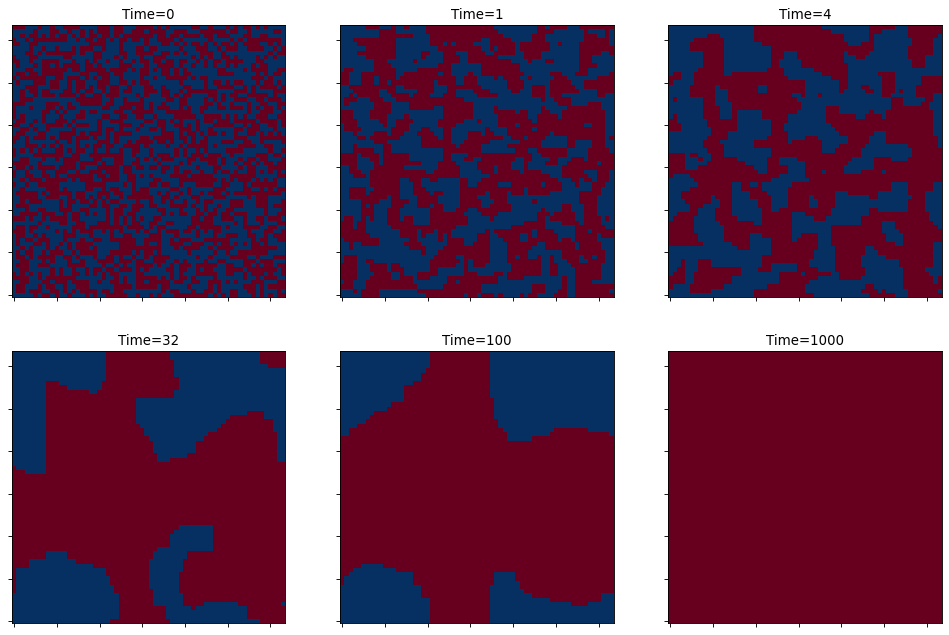

In [685]:
rm.simulate()

In [697]:
# Simulating the TDGL equation
# This example uses the 5-point Laplacian discretization from 
# [here](https://github.com/ketch/finite-difference-course)
#
%matplotlib inline
import numpy as np
from __future__ import division
from scipy.sparse import spdiags,linalg,eye
import matplotlib.pyplot as plt


a,b, k = 0, 1.0, 100.0
dh, dt = 1.0, 1e-3
Ng, Tf = 256, 10001

class TDGL():
    '''
    Class to solve a PDE 
    '''
    def mu(self, u):
        return a*u + b*u*u*u 

    def laplacian(self, Ng):
        '''Construct a sparse matrix that applies the 5-point Laplacian discretization'''
        e=np.ones(Ng**2)
        e2=([1]*(Ng-1)+[0])*Ng
        e3=([0]+[1]*(Ng-1))*Ng
        h=dh
        A=spdiags([-4*e,e2,e3,e,e],[0,-1,1,-Ng,Ng],Ng**2,Ng**2)
        A/=h**2
        return A

    def integrate(self, L, x, y, u):
        '''  simulates the equation and plots it at different instants '''
        
        f = plt.figure(figsize=(15, 15), dpi=80);    

        for i in range(Tf):          
            u = u - dt*(self.mu(u) - k*L.dot(u))
            
            if (i==0):      self.configPlot(x, y, u, f, 1, i);
            if (i==1):      self.configPlot(x, y, u, f, 2, i);
            if (i==10):     self.configPlot(x, y, u, f, 3, i);
            if (i==100):    self.configPlot(x, y, u, f, 4, i);
            if (i==1000):   self.configPlot(x, y, u, f, 5, i);
            if (i==10000):  self.configPlot(x, y, u, f, 6, i);
     
    def configPlot(self, x, y, u,f, n_, i):
        U= u.reshape((Ng, Ng))
        sp =  f.add_subplot(3, 3, n_ )  
        plt.setp(sp.get_yticklabels(), visible=False)
        plt.setp(sp.get_xticklabels(), visible=False)
        plt.pcolormesh(x,y,U, cmap=plt.cm.RdBu);
        plt.title('Time=%d'%i)
    plt.show()

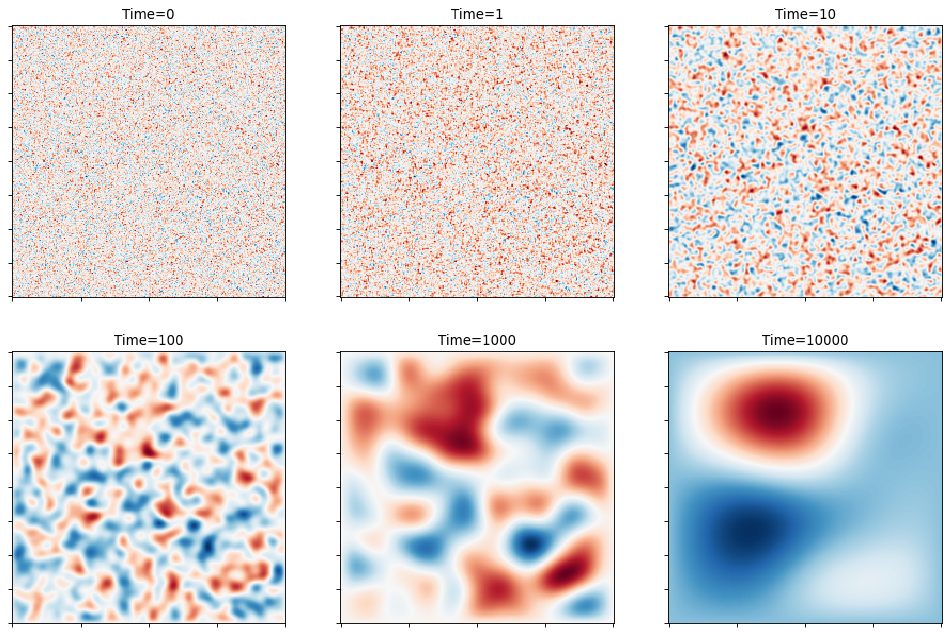

In [699]:
rm = TDGL()   # instantiate the class

# generate the grid and initialise the field
x = np.linspace(-1,1,Ng)
y = np.linspace(-1,1,Ng)
X, Y = np.meshgrid(x, y)

u=np.random.randn(Ng*Ng, 1);  # Initial data
L = rm.laplacian(Ng)         # construct the laplacian
rm.integrate(L, x, y, u)    # simulate

#simulation completed!!